In [ ]:
import os
import open3d as o3d
import numpy as np

PROJECT_ROOT = "/data1_ycao/chua/projects/cdTeacher"
MODELS_ROOT  = f"{PROJECT_ROOT}/web-viewer/models"

os.makedirs(MODELS_ROOT, exist_ok=True)

SEQS = [
    "c1_descending_t2_v2",
    "c2_rectum_t4_v3",
]

def export_colmap_dense(seq):
    # This uses your previous dense path template, change it if it's different
    colmap_dense_root = os.path.join(
        PROJECT_ROOT,
        "outputs",
        "stage_B",
        seq,
        "colmap_dense"
    )
    fused_path = os.path.join(colmap_dense_root, "fused.ply")
    if not os.path.exists(fused_path):
        raise FileNotFoundError(f"COLMAP fused.ply not found: {fused_path}")

    pcd = o3d.io.read_point_cloud(fused_path)
    pts = np.asarray(pcd.points)

    # If you have an "alignment transform" (R,t) from before, you can add R@pts.T + t.reshape(3,1) here
    # For now, assume they are already in the same coordinate system, which is enough for plotting.
    out_path = os.path.join(MODELS_ROOT, f"{seq}_colmap_dense_aligned.ply")
    o3d.io.write_point_cloud(out_path, pcd)
    print(f"[COLMAP] Saved {seq} dense cloud to {out_path} with {pts.shape[0]} points")

for seq in SEQS:
    export_colmap_dense(seq)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[COLMAP] Saved c1_descending_t2_v2 dense cloud to /data1_ycao/chua/projects/cdTeacher/web-viewer/models/c1_descending_t2_v2_colmap_dense_aligned.ply with 443036 points
[COLMAP] Saved c2_rectum_t4_v3 dense cloud to /data1_ycao/chua/projects/cdTeacher/web-viewer/models/c2_rectum_t4_v3_colmap_dense_aligned.ply with 4248 points


In [ ]:
import os
import gzip
import json
import numpy as np
import open3d as o3d

PROJECT_ROOT = "/data1_ycao/chua/projects/cdTeacher"
MODELS_ROOT  = f"{PROJECT_ROOT}/web-viewer/models"

os.makedirs(MODELS_ROOT, exist_ok=True)

# Change this according to the path when you ran ns-render dataset before:
# Example: /data1_ycao/chua/projects/cdTeacher/outputs/stage_D/<seq>/ns_raw_depth/test/raw-depth
def get_raw_depth_root(seq):
    # TODO: Change this to the directory where you actually store raw-depth
    return os.path.join(
        PROJECT_ROOT,
        "outputs",
        "stage_D",
        seq,
        "test",
        "raw-depth",
    )

def load_transforms(seq):
    tf_path = os.path.join(
        PROJECT_ROOT,
        "outputs",
        "stage_A",
        seq,
        "transforms.json",
    )
    with open(tf_path, "r") as f:
        meta = json.load(f)
    return meta

def build_pinhole_dirs(width, height, fx, fy, cx, cy):
    # Generate pinhole unit direction vectors (H,W,3)
    ys, xs = np.meshgrid(np.arange(height), np.arange(width), indexing="ij")
    x = (xs - cx) / fx
    y = (ys - cy) / fy
    z = np.ones_like(x)
    dirs = np.stack([x, y, z], axis=-1)
    norms = np.linalg.norm(dirs, axis=-1, keepdims=True)
    dirs = dirs / np.clip(norms, 1e-9, None)
    return dirs  # (H,W,3)

def export_nerf_points_for_seq(seq, alpha, max_points_per_frame=10000):
    print(f"\n[NeRF] Export points for {seq}, alpha={alpha}")
    raw_root = get_raw_depth_root(seq)
    meta = load_transforms(seq)

    W = meta["w"]
    H = meta["h"]
    fx = meta["fl_x"]
    fy = meta["fl_y"]
    cx = meta["cx"]
    cy = meta["cy"]

    dirs = build_pinhole_dirs(W, H, fx, fy, cx, cy)  # (H,W,3)

    # Extract T_c2w for each frame
    T_list = []
    for f in meta["frames"]:
        T = np.array(f["transform_matrix"], dtype=np.float32)  # (4,4)
        T_list.append(T)
    T_c2w_all = np.stack(T_list, axis=0)  # (N,4,4)

    all_pts = []

    # raw-depth filenames are usually 4-digit numbers like 0000.npy.gz
    files = sorted([f for f in os.listdir(raw_root) if f.endswith(".npy.gz")])
    print(f"Found {len(files)} raw-depth frames in {raw_root}")

    for fname in files:
        frame_id = int(os.path.splitext(os.path.splitext(fname)[0])[0])  # "0010.npy.gz" -> 10
        path = os.path.join(raw_root, fname)
        with gzip.open(path, "rb") as f:
            d = np.load(f)  # (H,W,1)

        depth = d[..., 0].astype(np.float32)  # (H,W)
        # Filter out invalid / nan / <=0
        valid = np.isfinite(depth) & (depth > 0)

        dirs_valid = dirs[valid]  # (Nv,3)
        d_valid = depth[valid]    # (Nv,)

        # raw-depth is "normalized depth" in unit range, restore to meters using alpha
        pts_cam = dirs_valid * (alpha * d_valid)[:, None]  # (Nv,3)

        T = T_c2w_all[frame_id]
        R = T[:3, :3]
        t = T[:3, 3]

        pts_world = (R @ pts_cam.T + t.reshape(3, 1)).T  # (Nv,3)

        if pts_world.shape[0] > max_points_per_frame:
            idx = np.random.choice(pts_world.shape[0], max_points_per_frame, replace=False)
            pts_world = pts_world[idx]

        all_pts.append(pts_world)

        print(f"Frame {frame_id:04d}: {pts_world.shape[0]} pts")

    if not all_pts:
        print("No points collected, check raw-depth path.")
        return

    pts_all = np.concatenate(all_pts, axis=0)
    print(f"Total NeRF points for {seq}: {pts_all.shape[0]}")

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts_all)

    out_path = os.path.join(MODELS_ROOT, f"{seq}_nerf_alpha_best.ply")
    o3d.io.write_point_cloud(out_path, pcd)
    print(f"[NeRF] Saved {seq} NeRF cloud to {out_path}")

# Based on our previous alpha-sweep results:
export_nerf_points_for_seq("c1_descending_t2_v2", alpha=0.10)
export_nerf_points_for_seq("c2_rectum_t4_v3",    alpha=0.05)


[NeRF] Export points for c1_descending_t2_v2, alpha=0.1
Found 61 raw-depth frames in /data1_ycao/chua/projects/cdTeacher/outputs/stage_D/c1_descending_t2_v2/test/raw-depth
Frame 0010: 10000 pts
Frame 0020: 10000 pts
Frame 0030: 10000 pts
Frame 0040: 10000 pts
Frame 0050: 10000 pts
Frame 0060: 10000 pts
Frame 0070: 10000 pts
Frame 0080: 10000 pts
Frame 0090: 10000 pts
Frame 0100: 10000 pts
Frame 0111: 10000 pts
Frame 0121: 10000 pts
Frame 0131: 10000 pts
Frame 0141: 10000 pts
Frame 0151: 10000 pts
Frame 0161: 10000 pts
Frame 0171: 10000 pts
Frame 0181: 10000 pts
Frame 0191: 10000 pts
Frame 0201: 10000 pts
Frame 0212: 10000 pts
Frame 0222: 10000 pts
Frame 0232: 10000 pts
Frame 0242: 10000 pts
Frame 0252: 10000 pts
Frame 0262: 10000 pts
Frame 0272: 10000 pts
Frame 0282: 10000 pts
Frame 0292: 10000 pts
Frame 0302: 10000 pts
Frame 0313: 10000 pts
Frame 0323: 10000 pts
Frame 0333: 10000 pts
Frame 0343: 10000 pts
Frame 0353: 10000 pts
Frame 0363: 10000 pts
Frame 0373: 10000 pts
Frame 0383: 1

Saved fig_cloud_compare.pdf


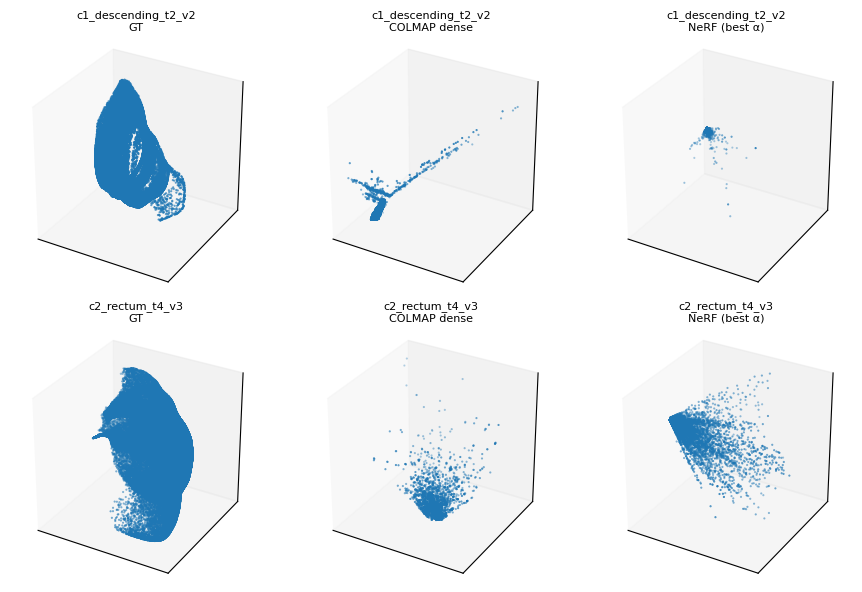

In [4]:
import os
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

PROJECT_ROOT = "/data1_ycao/chua/projects/cdTeacher"
MODELS_ROOT  = f"{PROJECT_ROOT}/web-viewer/models"

SEQS = [
    "c1_descending_t2_v2",
    "c2_rectum_t4_v3",
]

def load_ply_points(path, max_points=80000):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    pcd = o3d.io.read_point_cloud(path)
    pts = np.asarray(pcd.points)
    if pts.shape[0] > max_points:
        idx = np.random.choice(pts.shape[0], max_points, replace=False)
        pts = pts[idx]
    return pts

fig = plt.figure(figsize=(9, 6))

for row, seq in enumerate(SEQS):
    gt_path   = os.path.join(MODELS_ROOT, f"{seq}_gt_full.ply")
    sfm_path  = os.path.join(MODELS_ROOT, f"{seq}_colmap_dense_aligned.ply")
    nerf_path = os.path.join(MODELS_ROOT, f"{seq}_nerf_alpha_best.ply")

    pts_gt   = load_ply_points(gt_path)
    pts_sfm  = load_ply_points(sfm_path)
    pts_nerf = load_ply_points(nerf_path)

    clouds = [
        (pts_gt,   "GT"),
        (pts_sfm,  "COLMAP dense"),
        (pts_nerf, "NeRF (best α)"),
    ]

    for col, (pts, title) in enumerate(clouds):
        ax = fig.add_subplot(2, 3, row * 3 + col + 1, projection="3d")
        ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=0.3)
        ax.set_title(f"{seq}\n{title}", fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_box_aspect([1, 1, 1])

plt.tight_layout()
plt.savefig("fig_cloud_compare.pdf", bbox_inches="tight")
print("Saved fig_cloud_compare.pdf")
